In [1]:
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
from PIL import Image

from utils.plotting import showFlow, overlaySegment
from utils.encoding import dice_coeff
import time

import os
# Select a GPU for the work
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
available_gpus = [(torch.cuda.device(i),torch.cuda.get_device_name(i)) for i in range(torch.cuda.device_count())]
print(available_gpus)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

[(<torch.cuda.device object at 0x7fa08c0eaee0>, 'NVIDIA GeForce RTX 2080 Ti')]


device(type='cuda', index=0)

In [2]:
# check if the overlay works
def overlaySegment(gray1,seg1,flag=False):
    H, W = seg1.squeeze().size()
    colors=torch.FloatTensor([0,0,0,199,67,66,225,140,154,78,129,170,45,170,170,240,110,38,111,163,91,235,175,86,202,255,52,162,0,183]).view(-1,3)/255.0
    segs1 = labelMatrixOneHot(seg1.unsqueeze(0),3)

    seg_color = torch.mm(segs1.view(8,-1).t(),colors[:8,:]).view(H,W,3)
    alpha = torch.clamp(1.0 - 0.5*(seg1>0).float(),0,1.0)

    overlay = (gray1*alpha).unsqueeze(2) + seg_color*(1.0-alpha).unsqueeze(2)
    if(flag):
        plt.imshow((overlay).numpy())
        plt.show()
    return overlay
def labelMatrixOneHot(segmentation, label_num):
    B, H, W = segmentation.size()
    values = segmentation.view(B,1,H,W).expand(B,label_num,H,W).to(segmentation.device)
    linspace = torch.linspace(0, label_num-1, label_num).long().view(1,label_num,1,1).expand(B,label_num,H,W).to(segmentation.device)
    matrix = (values.float()==linspace.float()).float().to(segmentation.device)
    for j in range(2,matrix.shape[1]):
        matrix[0,j,:,:] = matrix[0,j,:,:]
    return matrix

In [3]:
W,H = (150,150)
o_m = H//4
o_n = W//4
ogrid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,o_m,o_n)).view(1,1,-1,2)#.cuda()
disp_range = 0.25#0.25
disp_hw = 5
displace_range = 11

grid_size = 32#25#30
grid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,grid_size,grid_size)).view(1,-1,1,2)#.cuda()


def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv1d):
        nn.init.xavier_normal(m.weight)
        if m.bias is not None:
            nn.init.constant(m.bias, 0.0)

class OBELISK2d(nn.Module):
    def __init__(self, chan = 16):

        super(OBELISK2d, self).__init__()
        channels = chan
        self.offsets = nn.Parameter(torch.randn(2,channels *2,2) *0.05)
        self.layer0 = nn.Conv2d(1, 4, 5, stride=2, bias=False, padding=2)
        self.batch0 = nn.BatchNorm2d(4)

        self.layer1 = nn.Conv2d(channels *8, channels *4, 1, bias=False, groups=1)
        self.batch1 = nn.BatchNorm2d(channels *4)
        self.layer2 = nn.Conv2d(channels *4, channels *4, 3, bias=False, padding=1)
        self.batch2 = nn.BatchNorm2d(channels *4)
        self.layer3 = nn.Conv2d(channels *4, channels *1, 1)
        

    def forward(self, input_img):
        img_in = F.avg_pool2d(input_img ,3 ,padding=1 ,stride=2)
        img_in = F.relu(self.batch0(self.layer0(img_in)))
        sampled = F.grid_sample(img_in ,ogrid_xy + self.offsets[0 ,:,:].view(1 ,-1 ,1 ,2)).view(1 ,-1 ,o_m ,o_n)
        sampled -= F.grid_sample(img_in ,ogrid_xy + self.offsets[1 ,:,:].view(1 ,-1 ,1 ,2)).view(1 ,-1 ,o_m ,o_n)

        x = F.relu(self.batch1(self.layer1(sampled)))
        x = F.relu(self.batch2(self.layer2(x)))
        features = self.layer3(x)
        return features
    
    
def min_convolution(ssd_distance, displace_range, H, W):
    # Prepare operators for smooth dense displacement space
    pad1 = nn.ReplicationPad2d(5)
    avg1 = nn.AvgPool2d(5,stride=1)
    max1 = nn.MaxPool2d(3,stride=1)
    pad2 = nn.ReplicationPad2d(6)
    # approximate min convolution / displacement compatibility

    ssd_minconv = avg1(avg1(-max1(-pad1(ssd_distance.permute(0,2,3,1).reshape(1,-1,displace_range,displace_range)))))

    ssd_minconv = ssd_minconv.permute(0,2,3,1).view(1,-1,H,W)
    min_conv_cost = avg1(avg1(avg1(pad2(ssd_minconv))))
    
    return min_conv_cost

def meanfield(ssd_distance,img_fixed,displace_range,H,W):

    crnt_dev = ssd_distance.device

    cost = min_convolution(ssd_distance, displace_range, H, W)

    soft_cost = F.softmax(-10*cost.view(displace_range**2,-1).t(),1)
    
    disp_hw = (displace_range-1)//2
    disp_mesh_grid = disp_hw*F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,displace_range,displace_range),align_corners=True)
    disp_mesh_grid /= torch.Tensor([(W-1)*.5,(H-1)*.5])

    disp_xy = torch.sum(soft_cost.view(1,H,W,-1,1)*disp_mesh_grid.view(1,1,1,-1,2).to(crnt_dev),3).permute(0,3,1,2) 
    

    return soft_cost,disp_xy

def correlation_layer(displace_range, feat_moving, feat_fixed):
    
    disp_hw = (displace_range-1)//2
    feat_moving_unfold = F.unfold(feat_moving.transpose(1,0),(displace_range,displace_range),padding=disp_hw)
    B,C,H,W = feat_fixed.size()
    
    ssd_distance = ((feat_moving_unfold-feat_fixed.view(C,1,-1))**2).sum(0).view(1,displace_range**2,H,W)

    return ssd_distance

/home/nicke/miniconda3/envs/flowenv/lib/python3.8/site-packages/torch/nn/functional.py:4043: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [1]:
path_to_state_dict = "models/Experiment_1/obel16_oneFixed_25_11_21-12-10.pth"
model_classic = OBELISK2d(16)
model_classic.load_state_dict(torch.load(path_to_state_dict))
model_classic.eval()

path_to_state_dict = "models/Experiment_2/obel16_ensemble_07_10_21-20-08.pth"
model_kc = OBELISK2d(16)
model_kc.load_state_dict(torch.load(path_to_state_dict))
model_kc.eval()

path_to_state_dict = "models/Experiment_3/27_10_21-10-59/student_16_0.pth"
model_dml = OBELISK2d(16)
model_dml.load_state_dict(torch.load(path_to_state_dict))
model_dml.eval()

NameError: name 'OBELISK2d' is not defined

In [10]:
baseline = cv2.optflow.DualTVL1OpticalFlow_create()

In [36]:
def baseline_infer(fixed, moving):
    # prepare for baseline
    in1 = moving.view(H,W,1).numpy().astype(np.float32)
    in2 = fixed.view(H,W,1).numpy().astype(np.float32)
    
    start = time.time()
    # run baseline
    baseline_flow = baseline.calc(in1,in2,None)
    end = time.time()
    run_time = round(end-start, 4)
    
    return torch.from_numpy(baseline_flow.T), run_time
    
def baseline_warp(fixed,moving, fixed_seg, moving_seg):
    flow, time = baseline_infer(fixed,moving)
    
    B, C, H, W = flow.unsqueeze(0).size()
    # mesh grid
    xx = torch.arange(0, W).view(1, -1).repeat(H, 1)
    yy = torch.arange(0, H).view(-1, 1).repeat(1, W)
    xx = xx.view(1, 1, H, W).repeat(B, 1, 1, 1)
    yy = yy.view(1, 1, H, W).repeat(B, 1, 1, 1)
    grid = torch.cat((xx, yy), 1).float()

    vgrid = grid + flow.unsqueeze(0)

    # scale grid to [-1,1]
    vgrid[:, 0, :, :] = 2.0 * vgrid[:, 0, :, :].clone() / max(W - 1, 1) - 1.0
    vgrid[:, 1, :, :] = 2.0 * vgrid[:, 1, :, :].clone() / max(H - 1, 1) - 1.0

    vgrid = vgrid.permute(0, 2, 3, 1)
    # TODO: Should we war the moving seg or fxed seg with a .fip() flow??
    warped_seg_grid = nn.functional.grid_sample(fixed_seg.float().unsqueeze(0).unsqueeze(0), vgrid)
    return warped_seg_grid, time

def pdd_warp(model, fixed, moving, fixed_seg, moving_seg):
    model.eval()
    
    start = time.time()
    feat1 = model(fixed.unsqueeze(0).unsqueeze(0))
    feat2 = model(moving.unsqueeze(0).unsqueeze(0))
    ssd_distance = correlation_layer(displace_range, feat2, feat1)
    soft_cost,disp_xy = meanfield(ssd_distance, fixed, displace_range, H//4, W//4)
    # scaling
    flow=F.interpolate(disp_xy,size=(150,150))
    end = time.time()
    run_time = round(end-start, 4)
    
    # TODO: what are we warping where?
    identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H,W),align_corners=False)
    warped_student_seg = F.grid_sample(moving_seg.unsqueeze(0).unsqueeze(0).float(),identity+flow.flip(1).permute(0,2,3,1),mode='nearest',align_corners=False).cpu()

    return warped_student_seg, run_time

In [37]:
def eval_id(frames, segs, last_segment_available):
    distance_between_frames = 6

    #soft_segs = torch.zeros(segs.shape)
    #classic_segs = torch.zeros(segs.shape)
    #kc_segs = torch.zeros(segs.shape)
    #dml_segs = torch.zeros(segs.shape)

    soft_dice = torch.zeros(frames.shape[0],2)
    classic_dice = torch.zeros(frames.shape[0],2)
    kc_dice = torch.zeros(frames.shape[0],2)
    dml_dice = torch.zeros(frames.shape[0],2)


    for i, frame in enumerate(frames):

        # skipp first X frames
        if i < distance_between_frames:
            continue
        moving = torch.clone(frames[i])
        fixed = torch.clone(frames[i- distance_between_frames])
        moving_seg = torch.clone(segs[i])
        fixed_seg = torch.clone(segs[i-distance_between_frames])


        # LABELLOSS
        pdd_seg, run_time_pdd = pdd_warp(model_classic, fixed, moving, fixed_seg, moving_seg)
        #classic_segs[i] = pdd_seg
        classic_dice[i] = dice_coeff(moving_seg, pdd_seg, 3)

        # KC
        pdd_seg, run_time_pdd = pdd_warp(model_kc, fixed, moving, fixed_seg, moving_seg)
        #kc_segs[i] = pdd_seg
        kc_dice[i] = dice_coeff(moving_seg, pdd_seg, 3)

        # DML
        pdd_seg, run_time_pdd = pdd_warp(model_dml, fixed, moving, fixed_seg, moving_seg)
        #dml_segs[i] = pdd_seg
        dml_dice[i] = dice_coeff(moving_seg, pdd_seg, 3)
        
         # SOFT
        pdd_seg, run_time_pdd = pdd_warp(model_soft, fixed, moving, fixed_seg, moving_seg)
        #soft_segs[i] = pdd_seg
        soft_dice[i] = dice_coeff(moving_seg, pdd_seg, 3)
        
    return classic_dice, kc_dice, dml_dice, soft_dice

/home/nicke/miniconda3/envs/flowenv/lib/python3.8/site-packages/torch/nn/functional.py:3981: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [1]:
path_to_data = "/share/data_ultraschall/compressions"
ids = [157, 384, 717, 1097, 1150, 1314, 58, 115, 2709, 2713,4814, 2199,545, 216, 610,341,526,12,124,1778,195,379,327,384,2033,797]
overall_classic_dice = []
overall_kc_dice = []
overall_dml_dice = []
overall_soft_dice = []

for prob_id in ids:
    
    frame_path = os.path.join(path_to_data,str(prob_id),'frames')
    seg_path = os.path.join(path_to_data,str(prob_id),'segmentations','1')

    frame_list = []
    for frame in os.listdir(frame_path):
        frame_list.append(os.path.join(frame_path,frame))
    frame_list.sort()

    seg_list = []
    for seg in os.listdir(seg_path):
        seg_list.append(os.path.join(seg_path,seg))
    seg_list.sort()

    assert len(frame_list) == len(seg_list)
    frames = torch.zeros([len(frame_list), 150,150])
    segs = torch.zeros([len(frame_list), 150,150])
    for i in range(len(frame_list)):
        frames[i] = torch.from_numpy(np.array(Image.open(frame_list[i]))) / 255
        segs[i] = (torch.from_numpy(np.array(Image.open(seg_list[i]))) / 100)

    landmarks = pd.read_csv('landmarks.csv')
    landmarks[landmarks['Id'].isin(ids)]

    last_segment_available = np.fromstring(landmarks[landmarks['Id']== prob_id]['Start Frames'].iat[0].strip(']['), sep=',', dtype=int)[0]
    c_d, kc_d, dml_d, soft_d = eval_id(frames,segs, last_segment_available)
    overall_classic_dice.append(c_d)
    overall_kc_dice.append(kc_d)
    overall_dml_dice.append(dml_d)
    overall_soft_dice.append(soft_d)

NameError: name 'os' is not defined

<IPython.core.display.Javascript object>


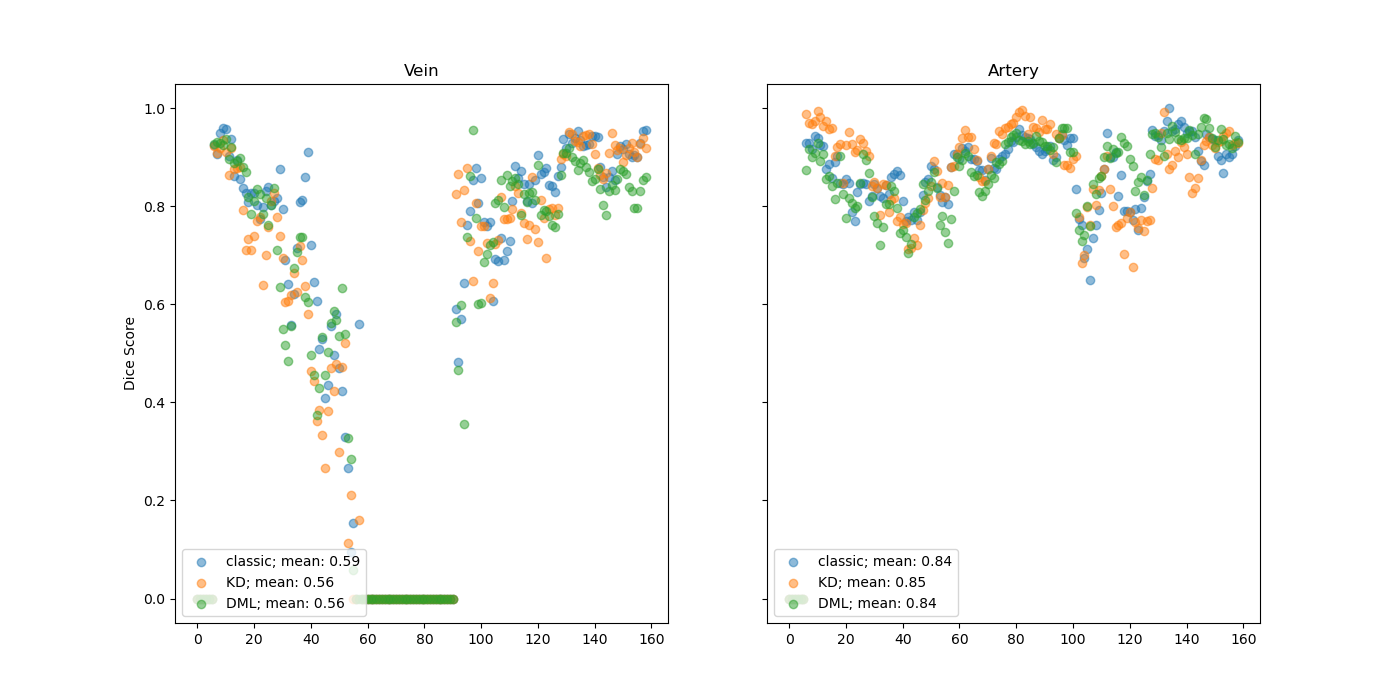

In [38]:
%matplotlib notebook
fig, ax = plt.subplots(1,2, figsize=(14,7), sharey=True)
#ax[0].scatter(np.arange(len(baseline_dice)), baseline_dice[:,0], label= f'baseline; mean: {round(baseline_dice[:,0].mean().item(),2)}', alpha=0.5)
ax[0].scatter(np.arange(len(classic_dice)), classic_dice[:,0], label= f'classic; mean: {round(classic_dice[:,0].mean().item(),2)}', alpha=0.5)
ax[0].scatter(np.arange(len(kc_dice)), kc_dice[:,0], label= f'KD; mean: {round(kc_dice[:,0].mean().item(),2)}', alpha=0.5)
ax[0].scatter(np.arange(len(dml_dice)), dml_dice[:,0], label= f'DML; mean: {round(dml_dice[:,0].mean().item(),2)}', alpha=0.5)
ax[0].set_title('Vein')
ax[0].set_ylabel('Dice Score')
ax[0].legend(loc='lower left')

#ax[1].scatter(np.arange(len(baseline_dice)), baseline_dice[:,1], label= f'baseline; mean: {round(baseline_dice[:,1].mean().item(),2)}', alpha=0.5)
ax[1].scatter(np.arange(len(classic_dice)), classic_dice[:,1], label=f'classic; mean: {round(classic_dice[:,1].mean().item(),2)}', alpha=0.5)
ax[1].scatter(np.arange(len(kc_dice)), kc_dice[:,1], label=f'KD; mean: {round(kc_dice[:,1].mean().item(),2)}', alpha=0.5)
ax[1].scatter(np.arange(len(dml_dice)), dml_dice[:,1], label=f'DML; mean: {round(dml_dice[:,1].mean().item(),2)}', alpha=0.5)

ax[1].set_title('Artery')
ax[1].legend(loc='lower left')

<IPython.core.display.Javascript object>


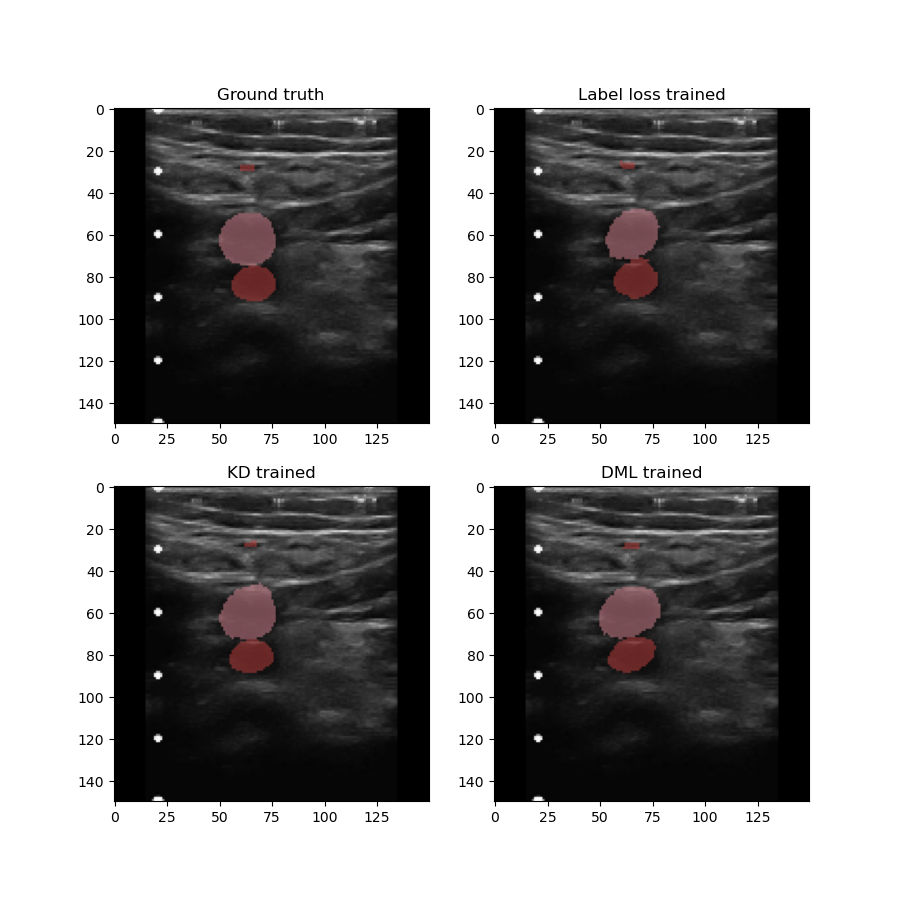

In [39]:
%matplotlib notebook

fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

ax1.set_title('Ground truth')
ax2.set_title('Label loss trained')
ax3.set_title('KD trained')
ax4.set_title('DML trained')


lines = []
for i in range(len(frames)):
    overlay_ground = overlaySegment(frames[i], segs[i])
    overlay_classic = overlaySegment(frames[i], classic_segs[i].squeeze())
    overlay_kc = overlaySegment(frames[i], kc_segs[i].squeeze())
    overlay_dml = overlaySegment(frames[i], dml_segs[i].squeeze())
    
    ground_truth_image = ax1.imshow(overlay_ground, animated=True)
    classic_image = ax2.imshow(overlay_classic, animated=True)
    kc_image = ax3.imshow(overlay_kc, animated=True)
    dml_image = ax4.imshow(overlay_dml, animated=True)
    
    lines.append([ground_truth_image,classic_image, kc_image,dml_image])
    
ani = animation.ArtistAnimation(fig,lines,interval=50,blit=True)
plt.show()

In [40]:
ani.save(f'/share/data_ultraschall/nicke_ma/eval_videos/each_frame_compare_{prob_id}.mp4')

# Last Fixed available

In [41]:
distance_between_frames = 6

base_segs = torch.zeros(segs.shape)
classic_segs = torch.zeros(segs.shape)
kc_segs = torch.zeros(segs.shape)
dml_segs = torch.zeros(segs.shape)


baseline_time = torch.zeros(frames.shape[0] - distance_between_frames)
classic_time = torch.zeros(frames.shape[0] - distance_between_frames)
kc_time = torch.zeros(frames.shape[0] - distance_between_frames)
dml_time = torch.zeros(frames.shape[0] - distance_between_frames)


baseline_dice = torch.zeros(frames.shape[0],2)
classic_dice = torch.zeros(frames.shape[0],2)
kc_dice = torch.zeros(frames.shape[0],2)
dml_dice = torch.zeros(frames.shape[0],2)
for i, frame in enumerate(frames):
    
    # skipp first X frames
    if i < distance_between_frames:
        continue
    if i-distance_between_frames <= last_segment_available:
        fixed = torch.clone(frames[i- distance_between_frames])
        fixed_seg = torch.clone(segs[i-distance_between_frames])
    
    if i-distance_between_frames > last_segment_available:
        fixed = torch.clone(frames[last_segment_available])
        fixed_seg = torch.clone(segs[last_segment_available])
    
    moving = torch.clone(frames[i])
    moving_seg = torch.clone(segs[i])
    
        # BASELINE
    baseline_seg, run_time_base = baseline_warp(fixed,moving, fixed_seg, moving_seg)
    base_segs[i] = baseline_seg
    baseline_time[i-distance_between_frames] = run_time_base
    baseline_dice[i] = dice_coeff(moving_seg, baseline_seg, 3)
    
    # LABELLOSS
    pdd_seg, run_time_pdd = pdd_warp(model_classic, fixed, moving, fixed_seg, moving_seg)
    classic_segs[i] = pdd_seg
    classic_time[i-distance_between_frames] = run_time_pdd
    classic_dice[i] = dice_coeff(moving_seg, pdd_seg, 3)
    
    # KC
    pdd_seg, run_time_pdd = pdd_warp(model_kc, fixed, moving, fixed_seg, moving_seg)
    kc_segs[i] = pdd_seg
    kc_time[i-distance_between_frames] = run_time_pdd
    kc_dice[i] = dice_coeff(moving_seg, pdd_seg, 3)
    
    # DML
    pdd_seg, run_time_pdd = pdd_warp(model_dml, fixed, moving, fixed_seg, moving_seg)
    dml_segs[i] = pdd_seg
    dml_time[i-distance_between_frames] = run_time_pdd
    dml_dice[i] = dice_coeff(moving_seg, pdd_seg, 3)

/home/nicke/miniconda3/envs/flowenv/lib/python3.8/site-packages/torch/nn/functional.py:3981: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


<IPython.core.display.Javascript object>


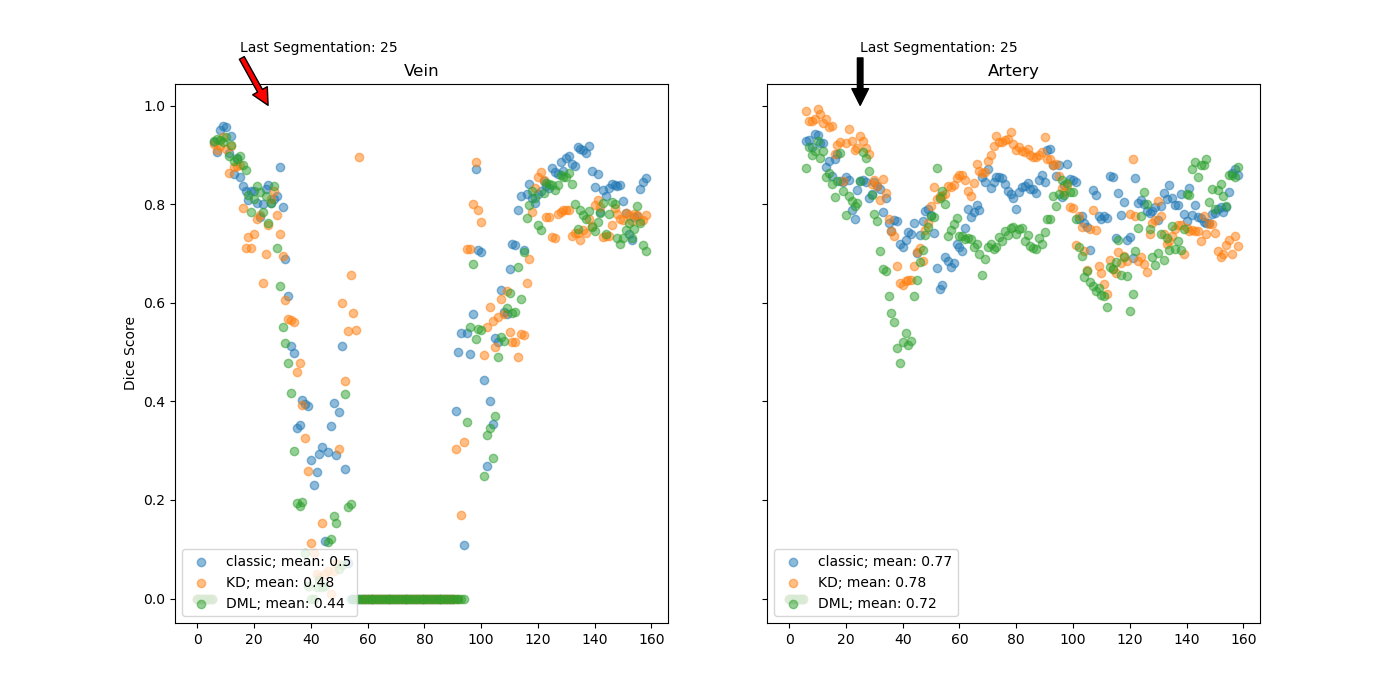

In [43]:
%matplotlib notebook
fig, ax = plt.subplots(1,2, figsize=(14,7), sharey=True)
#ax[0].scatter(np.arange(len(baseline_dice)), baseline_dice[:,0], label= f'baseline; mean: {round(baseline_dice[:,0].mean().item(),2)}', alpha=0.5)
ax[0].scatter(np.arange(len(classic_dice)), classic_dice[:,0], label= f'classic; mean: {round(classic_dice[:,0].mean().item(),2)}', alpha=0.5)
ax[0].scatter(np.arange(len(kc_dice)), kc_dice[:,0], label= f'KD; mean: {round(kc_dice[:,0].mean().item(),2)}', alpha=0.5)
ax[0].scatter(np.arange(len(dml_dice)), dml_dice[:,0], label= f'DML; mean: {round(dml_dice[:,0].mean().item(),2)}', alpha=0.5)
ax[0].set_title('Vein')
ax[0].set_ylabel('Dice Score')
ax[0].legend(loc='lower left')
ax[0].annotate(f"Last Segmentation: {last_segment_available}", xy=(last_segment_available, 1), xytext=(last_segment_available-10, 1.11),arrowprops=dict(facecolor='red', shrink=0.01))


#ax[1].scatter(np.arange(len(baseline_dice)), baseline_dice[:,1], label= f'baseline; mean: {round(baseline_dice[:,1].mean().item(),2)}', alpha=0.5)
ax[1].scatter(np.arange(len(classic_dice)), classic_dice[:,1], label=f'classic; mean: {round(classic_dice[:,1].mean().item(),2)}', alpha=0.5)
ax[1].scatter(np.arange(len(kc_dice)), kc_dice[:,1], label=f'KD; mean: {round(kc_dice[:,1].mean().item(),2)}', alpha=0.5)
ax[1].scatter(np.arange(len(dml_dice)), dml_dice[:,1], label=f'DML; mean: {round(dml_dice[:,1].mean().item(),2)}', alpha=0.5)
ax[1].set_title('Artery')
ax[1].annotate(f"Last Segmentation: {last_segment_available}", xy=(last_segment_available, 1), xytext=(last_segment_available, 1.11),arrowprops=dict(facecolor='black', shrink=0.01))
ax[1].legend(loc='lower left')

<IPython.core.display.Javascript object>


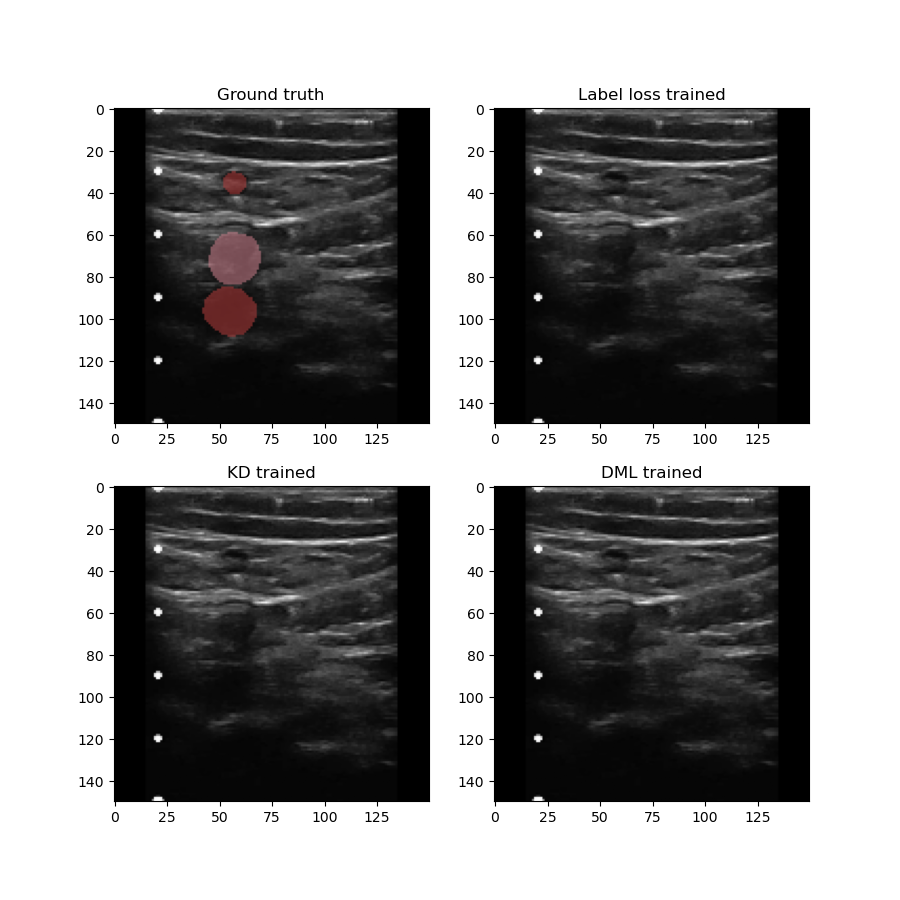

In [44]:
%matplotlib notebook

fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

ax1.set_title('Ground truth')
ax2.set_title('Label loss trained')
ax3.set_title('KD trained')
ax4.set_title('DML trained')


lines = []
for i in range(len(frames)):
    overlay_ground = overlaySegment(frames[i], segs[i])
    overlay_classic = overlaySegment(frames[i], classic_segs[i].squeeze())
    overlay_kc = overlaySegment(frames[i], kc_segs[i].squeeze())
    overlay_dml = overlaySegment(frames[i], dml_segs[i].squeeze())
    
    ground_truth_image = ax1.imshow(overlay_ground, animated=True)
    classic_image = ax2.imshow(overlay_classic, animated=True)
    kc_image = ax3.imshow(overlay_kc, animated=True)
    dml_image = ax4.imshow(overlay_dml, animated=True)
    
    lines.append([ground_truth_image,classic_image, kc_image,dml_image])
    
ani = animation.ArtistAnimation(fig,lines,interval=50,blit=True)
plt.show()

In [45]:
ani.save(f'/share/data_ultraschall/nicke_ma/eval_videos/last_available_fixed_compare_{prob_id}.mp4')

# Using Not all segmentations

In [ ]:
path_to_data = "/share/data_ultraschall/compressions"
ids = [157,195,379,327,384,717,2033,797] # best ones 384, 717
prob_id= str(ids[5])
frame_path = os.path.join(path_to_data,prob_id,'frames')
seg_path = os.path.join(path_to_data,prob_id,'segmentations','1')

frame_list = []
for frame in os.listdir(frame_path):
    frame_list.append(os.path.join(frame_path,frame))
frame_list.sort()

seg_list = []
for seg in os.listdir(seg_path):
    seg_list.append(os.path.join(seg_path,seg))
seg_list.sort()

assert len(frame_list) == len(seg_list)

frames = torch.zeros([len(frame_list), 150,150])
segs = torch.zeros([len(frame_list), 150,150])
for i in range(len(frame_list)):
    frames[i] = torch.from_numpy(np.array(Image.open(frame_list[i]))) / 255
    segs[i] = torch.from_numpy(np.array(Image.open(seg_list[i]))) / 100

In [ ]:
landmarks = pd.read_csv('landmarks.csv')
landmarks[landmarks['Id'].isin(ids)]

In [ ]:
last_segment_available = np.fromstring(landmarks[landmarks['Id']== int(prob_id)]['Start Frames'].iat[0].strip(']['), sep=',', dtype=int)[0]
last_segment_available

# Propagating the Segmentation
Using the propagated segmentation for the Frames, where it is no longer available.

In [ ]:
# trained distance between the frames
distance_between_frames = 6

# storing list for the inference times per frame pair
times = []

# Storing Tensor for the warped segmentations and flowfields
warped_segs = torch.zeros(len(frames),1,150,150)
flow_fields = torch.ones(len(frames),2,150,150)
# Identitiy matrix for warping
identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H,W),align_corners=False).cuda()

# last available segmentation extracted from landmark.csv
last_segment_available = np.fromstring(landmarks[landmarks['Id']== int(prob_id)]['Start Frames'].iat[0].strip(']['), sep=',', dtype=int)[0]

# first feat extracted here
fixed = torch.clone(frames[0].unsqueeze(0).unsqueeze(0))
fixed_feat = model(fixed.cuda()).detach()

# iterate over the frames for segmentation propagation
for i, frame in enumerate(frames):
    # we cannot infer anything here
    if i < distance_between_frames:
        continue
        
    # segmentations are available, so we can use them
    if i-distance_between_frames <= last_segment_available:
        # segmentation to warp is taken from ground trouth segs
        fixed_seg = torch.clone(segs[i-distance_between_frames].unsqueeze(0).unsqueeze(0))
    # no ground truth is available
    elif i-distance_between_frames > last_segment_available:
        # so we use the warped segment 
        fixed_seg = warped_segs[i-distance_between_frames].unsqueeze(0)
    
    # moving Frame, aka the frame the segmentation is needed for
    fixed = torch.clone(frames[i-distance_between_frames].unsqueeze(0).unsqueeze(0))
    moving = torch.clone(frames[i].unsqueeze(0).unsqueeze(0))
    
    # start measuring time
    startTime = time.time()
    # etract featuers for moving frame
    moving_feat = model(moving.cuda()).detach()
    fixed_feat = model(fixed.cuda()).detach()
    
    # compute the currelation and flow field
    ssd_distance = correlation_layer(displace_range, moving_feat, fixed_feat).contiguous()
    #regularise using meanfield inference with approx. min-convolutions
    soft_cost_one,disp_xy = meanfield(ssd_distance, fixed, displace_range, H//4, W//4)
    #upsample field to original resolution
    dense_flow_fit = F.interpolate(disp_xy,size=(H,W),mode='bilinear', align_corners=False)#.cuda()
    
    #apply and evaluate transformation
    warped_seg = F.grid_sample(fixed_seg.cuda().float(),identity+dense_flow_fit.flip(1).permute(0,2,3,1),mode='nearest',align_corners=False).cpu()
    
    # Override the features so to not extract them again
    #fixed_feat = torch.clone(moving_feat)
    # end measuring time
    endTime = time.time()
    times.append(endTime - startTime)
    
    # store the warped seg
    warped_segs[i] = torch.clone(warped_seg.cpu())
    flow_fields[i] = dense_flow_fit


    

In [ ]:
%matplotlib notebook

plt.scatter(np.arange(len(frames)-distance_between_frames), times)
plt.plot(np.arange(len(frames)-distance_between_frames), np.full(len(times), np.mean(times)), color='r', label=f'Mean Time = {np.round(np.mean(times),3)}s per frame')
plt.ylabel('Time in seconds')
plt.xlabel('Frame Number')
plt.legend()
#plt.savefig(f'plots/runtime_on_{available_gpus[0][1]}.png')

Mean of 0.00225 seonds per frame. Taking the upper area of 0.00275 seconds per frame, the method can run with 1/0.00275 =   362fps. On a GTX 2080Ti. 

On the CPU of the server, the mean is around 0.03, which translates to 1/0.03 = 33 FPS

In [ ]:
%matplotlib notebook

fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

ax1.set_title('Ground truth')
ax2.set_title('Flow field')
ax3.set_title('Warped Segs')

lines = []
for i in range(len(frames)):
    overlay_ground = overlaySegment(frames[i], segs[i])
    overlay_warped = overlaySegment(frames[i], warped_segs[i].squeeze())
    flow_field = showFlow(flow_fields[i])
    
    ground_truth_image = ax1.imshow(overlay_ground, animated=True)
    visualised_flow_field = ax2.imshow(flow_field, animated=True)
    warped_segmentation_image = ax3.imshow(overlay_warped, animated=True)
    
    lines.append([ground_truth_image,warped_segmentation_image, visualised_flow_field])
    
ani = animation.ArtistAnimation(fig,lines,interval=50,blit=True)
plt.show()

In [ ]:
ani.save(f'/share/data_ultraschall/nicke_ma/eval_videos/propagate_fixed_seg_{prob_id}_{mode}.mp4')

# Using last fixed label
using the last segmentation available and then trying to warp it to the existing moving frame

In [ ]:
# trained distance between the frames
distance_between_frames = 6

# storing list for the inference times per frame pair
times = []

# Storing Tensor for the warped segmentations and flowfields
warped_segs = torch.zeros(len(frames),1,150,150)
flow_fields = torch.ones(len(frames),2,150,150)
# Identitiy matrix for warping
identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H,W),align_corners=False).cuda()

# last available segmentation extracted from landmark.csv
last_segment_available = np.fromstring(landmarks[landmarks['Id']== int(prob_id)]['Start Frames'].iat[0].strip(']['), sep=',', dtype=int)[0]

# first feat extracted here
fixed = torch.clone(frames[0].unsqueeze(0).unsqueeze(0))
fixed_feat = model(fixed.cuda()).detach()

# iterate over the frames for segmentation propagation
for i, frame in enumerate(frames):
    # we cannot infer anything here
    if i < distance_between_frames:
        continue
    
    # we select the segmentation available
    if i- distance_between_frames < last_segment_available:
        fixed = torch.clone(frames[i - distance_between_frames].unsqueeze(0).unsqueeze(0))
        fixed_seg = torch.clone(segs[i - distance_between_frames]).unsqueeze(0).unsqueeze(0)

    # Otherwise stick with the last available segmentation and Frame
    else:
        fixed = torch.clone(frames[last_segment_available].unsqueeze(0).unsqueeze(0))
        fixed_seg = torch.clone(segs[last_segment_available]).unsqueeze(0).unsqueeze(0)
        fixed_feat = model(fixed.cuda()).detach()
    
    # Moving Frame here
    moving = torch.clone(frames[i].unsqueeze(0).unsqueeze(0))
    
    # start measuring time
    startTime = time.time()
    # etract featuers for moving frame
    moving_feat = model(moving.cuda()).detach()
    
    
    # compute the currelation and flow field
    ssd_distance = correlation_layer(displace_range, moving_feat, fixed_feat).contiguous()
    #regularise using meanfield inference with approx. min-convolutions
    soft_cost_one,disp_xy = meanfield(ssd_distance, fixed, displace_range, H//4, W//4)
    #upsample field to original resolution
    dense_flow_fit = F.interpolate(disp_xy,size=(H,W),mode='bicubic', align_corners=False)#.cuda()
    #apply and evaluate transformation
    warped_seg = F.grid_sample(fixed_seg.cuda().float(),identity+dense_flow_fit.flip(1).permute(0,2,3,1),mode='nearest',align_corners=False).cpu()
    
    # Override the features so to not extract them again
    #fixed_feat = torch.clone(moving_feat)
    # end measuring time
    endTime = time.time()
    times.append(endTime - startTime)
    
    # store the warped seg
    warped_segs[i] = torch.clone(warped_seg.cpu())
    flow_fields[i] = dense_flow_fit

In [ ]:
%matplotlib notebook

plt.scatter(np.arange(len(frames)-distance_between_frames), times)
plt.plot(np.arange(len(frames)-distance_between_frames), np.full(len(times), np.mean(times)), color='r', label=f'Mean Time = {np.round(np.mean(times),3)}s per frame')
plt.ylabel('Time in seconds')
plt.xlabel('Frame Number')
plt.legend()

In [ ]:
%matplotlib notebook

fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

ax1.set_title('Ground truth')
ax2.set_title('Flow field')
ax3.set_title('Warped Segs')

lines = []
for i in range(len(frames)):
    overlay_ground = overlaySegment(frames[i], segs[i])
    overlay_warped = overlaySegment(frames[i], warped_segs[i].squeeze())
    flow_field = showFlow(flow_fields[i])
    
    ground_truth_image = ax1.imshow(overlay_ground, animated=True)
    visualised_flow_field = ax2.imshow(flow_field, animated=True)
    warped_segmentation_image = ax3.imshow(overlay_warped, animated=True)
    
    lines.append([ground_truth_image,warped_segmentation_image, visualised_flow_field])
    
ani = animation.ArtistAnimation(fig,lines,interval=50,blit=True)
plt.show()

In [ ]:
ani.save(f'/share/data_ultraschall/nicke_ma/eval_videos/always_use_last_fixed_seg_{prob_id}_{mode}.mp4')

# Showing Videos here

In [ ]:
from IPython.display import Video

In [ ]:
ids = [157,195,379,327,384,717,2033,797]

In [ ]:
prob_id= str(ids[-1])

In [ ]:
mode='DML'

In [ ]:
Video(f'/share/data_ultraschall/nicke_ma/eval_videos/propagate_last_fixed_seg_{prob_id}_{mode}.mp4', embed=True)